## Load Dataset

In [19]:
from image_datasets.IXIdataset import IXIDataset
from sklearn.model_selection import train_test_split

root = "/lustre/fswork/projects/rech/krk/usy14zi/datasets/IXI-dataset/size64/"
dataset = IXIDataset(root, mode="train")

train_set, val_set = train_test_split(dataset, train_size=420, test_size=40)

channels, image_size, _ = dataset[0]['T1'].shape
print(f"Train set size: {len(train_set)}.")
print(f"Validation set size: {len(val_set)}.")
print(f"Image of size {image_size}, with {channels} channel(s).")

Train set size: 420.
Validation set size: 40.
Image of size 64, with 1 channel(s).


In [20]:
from torch.utils.data import DataLoader

batch_size = 20

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=False,
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
)

## Initialize denoising model

In [21]:
import torch 
from model.unet import Unet
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

summary(model)
#print(sum(p.numel() for p in model.parameters() if p.requires_grad))

Layer (type:depth-idx)                                       Param #
Unet                                                         --
├─Conv2d: 1-1                                                128
├─Sequential: 1-2                                            --
│    └─SinusoidalPositionEmbeddings: 2-1                     --
│    └─Linear: 2-2                                           16,640
│    └─GELU: 2-3                                             --
│    └─Linear: 2-4                                           65,792
├─ModuleList: 1-3                                            --
│    └─ModuleList: 2-5                                       --
│    │    └─ResnetBlock: 3-1                                 107,008
│    │    └─ResnetBlock: 3-2                                 107,008
│    │    └─Residual: 3-3                                    33,088
│    │    └─Sequential: 3-4                                  16,448
│    └─ModuleList: 2-6                                       --
│    │  

## Initialize diffusion class

In [22]:
from diffusion.time_scheduler import quadratic_beta_schedule

timesteps = 600
betas = quadratic_beta_schedule(timesteps, beta_start=0.00001, beta_end=0.01)

In [23]:
from diffusion.diffusion import DiffusionModel

ddpm = DiffusionModel(model, timesteps, betas, device, loss_type='huber')

## Train the model

In [24]:
from torch.optim import Adam

epochs = 100
optimizer = Adam(model.parameters(), lr=3e-4)

In [25]:
ddpm.train(epochs, optimizer, train_loader, val_loader)

Epoch 0: 100%|##########| 21/21 [00:01<00:00, 11.89it/s]


Train Loss: 0.6971231017793927
Val Loss: 0.1317921318113804


Epoch 1: 100%|##########| 21/21 [00:01<00:00, 11.95it/s]


Train Loss: 0.35499619089421774
Val Loss: 0.1480269841849804


Epoch 2: 100%|##########| 21/21 [00:01<00:00, 12.14it/s]


Train Loss: 0.34571816878659384
Val Loss: 0.13954897969961166


Epoch 3: 100%|##########| 21/21 [00:01<00:00, 12.19it/s]


Train Loss: 0.2722770706528709
Val Loss: 0.09145768731832504


Epoch 4: 100%|##########| 21/21 [00:01<00:00, 11.95it/s]


Train Loss: 0.19515135139226913
Val Loss: 0.08284801617264748


Epoch 5: 100%|##########| 21/21 [00:01<00:00, 11.95it/s]


Train Loss: 0.19889150666339056
Val Loss: 0.08269596472382545


Epoch 6: 100%|##########| 21/21 [00:01<00:00, 12.18it/s]


Train Loss: 0.16551030852964946
Val Loss: 0.08661454916000366


Epoch 7: 100%|##########| 21/21 [00:01<00:00, 11.81it/s]


Train Loss: 0.15208669006824493
Val Loss: 0.06921648606657982


Epoch 8: 100%|##########| 21/21 [00:01<00:00, 12.14it/s]


Train Loss: 0.15647707453795842
Val Loss: 0.0694864634424448


Epoch 9: 100%|##########| 21/21 [00:01<00:00, 12.24it/s]


Train Loss: 0.14835884741374425
Val Loss: 0.04299025423824787


Epoch 10: 100%|##########| 21/21 [00:01<00:00, 11.92it/s]


Train Loss: 0.12255025921123368
Val Loss: 0.05164690129458904


Epoch 11: 100%|##########| 21/21 [00:01<00:00, 11.00it/s]


Train Loss: 0.1256715790146873
Val Loss: 0.048922304064035416


Epoch 12: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.14137455891995204
Val Loss: 0.052425703033804893


Epoch 13: 100%|##########| 21/21 [00:01<00:00, 11.80it/s]


Train Loss: 0.12563537841751463
Val Loss: 0.07712236046791077


Epoch 14: 100%|##########| 21/21 [00:01<00:00, 12.24it/s]


Train Loss: 0.12229963995161511
Val Loss: 0.060614777728915215


Epoch 15: 100%|##########| 21/21 [00:01<00:00, 12.18it/s]


Train Loss: 0.12544991217908405
Val Loss: 0.0662740170955658


Epoch 16: 100%|##########| 21/21 [00:01<00:00, 11.82it/s]


Train Loss: 0.11158035358502752
Val Loss: 0.05366981402039528


Epoch 17: 100%|##########| 21/21 [00:01<00:00, 12.23it/s]


Train Loss: 0.11340940495332082
Val Loss: 0.053645988926291466


Epoch 18: 100%|##########| 21/21 [00:01<00:00, 12.23it/s]


Train Loss: 0.11838404834270477
Val Loss: 0.051670217886567116


Epoch 19: 100%|##########| 21/21 [00:01<00:00, 11.86it/s]


Train Loss: 0.10739173988501231
Val Loss: 0.054939014837145805


Epoch 20: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.10167949841845603
Val Loss: 0.06267513334751129


Epoch 21: 100%|##########| 21/21 [00:01<00:00, 12.20it/s]


Train Loss: 0.09628586488820258
Val Loss: 0.065092071890831


Epoch 22: 100%|##########| 21/21 [00:01<00:00, 11.82it/s]


Train Loss: 0.10371958038636617
Val Loss: 0.05203462950885296


Epoch 23: 100%|##########| 21/21 [00:01<00:00, 12.23it/s]


Train Loss: 0.09211189370779764
Val Loss: 0.04315166175365448


Epoch 24: 100%|##########| 21/21 [00:01<00:00, 12.23it/s]


Train Loss: 0.09519315599685624
Val Loss: 0.05015348643064499


Epoch 25: 100%|##########| 21/21 [00:01<00:00, 11.85it/s]


Train Loss: 0.09550549941403526
Val Loss: 0.040613044053316116


Epoch 26: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.09680423087307385
Val Loss: 0.03782351687550545


Epoch 27: 100%|##########| 21/21 [00:01<00:00, 12.13it/s]


Train Loss: 0.09794161326828457
Val Loss: 0.04300895892083645


Epoch 28: 100%|##########| 21/21 [00:01<00:00, 11.92it/s]


Train Loss: 0.08398889572847457
Val Loss: 0.05356230400502682


Epoch 29: 100%|##########| 21/21 [00:01<00:00, 12.23it/s]


Train Loss: 0.09515329113318807
Val Loss: 0.045212604105472565


Epoch 30: 100%|##########| 21/21 [00:01<00:00, 12.14it/s]


Train Loss: 0.1014479799639611
Val Loss: 0.05517022870481014


Epoch 31: 100%|##########| 21/21 [00:01<00:00, 11.96it/s]


Train Loss: 0.09593875315927324
Val Loss: 0.044246415607631207


Epoch 32: 100%|##########| 21/21 [00:01<00:00, 12.18it/s]


Train Loss: 0.09485612117818423
Val Loss: 0.030900519341230392


Epoch 33: 100%|##########| 21/21 [00:01<00:00, 12.06it/s]


Train Loss: 0.09750051672259967
Val Loss: 0.03949868865311146


Epoch 34: 100%|##########| 21/21 [00:01<00:00, 11.94it/s]


Train Loss: 0.08419579994820413
Val Loss: 0.04412947781383991


Epoch 35: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.08957622572779655
Val Loss: 0.032156466506421566


Epoch 36: 100%|##########| 21/21 [00:01<00:00, 12.15it/s]


Train Loss: 0.08914856665900775
Val Loss: 0.04902965761721134


Epoch 37: 100%|##########| 21/21 [00:01<00:00, 11.56it/s]


Train Loss: 0.08884530000033833
Val Loss: 0.04220352694392204


Epoch 38: 100%|##########| 21/21 [00:01<00:00, 12.16it/s]


Train Loss: 0.09361296767989795
Val Loss: 0.037506917491555214


Epoch 39: 100%|##########| 21/21 [00:01<00:00, 12.19it/s]


Train Loss: 0.09683333798533394
Val Loss: 0.041747115552425385


Epoch 40: 100%|##########| 21/21 [00:01<00:00, 11.97it/s]


Train Loss: 0.08502795760120664
Val Loss: 0.06600109674036503


Epoch 41: 100%|##########| 21/21 [00:01<00:00, 12.17it/s]


Train Loss: 0.08873055041545913
Val Loss: 0.041396286338567734


Epoch 42: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.07847122014278457
Val Loss: 0.040191467851400375


Epoch 43: 100%|##########| 21/21 [00:01<00:00, 11.92it/s]


Train Loss: 0.08460577807965733
Val Loss: 0.034425195306539536


Epoch 44: 100%|##########| 21/21 [00:01<00:00, 12.05it/s]


Train Loss: 0.10035212302491778
Val Loss: 0.04344436340034008


Epoch 45: 100%|##########| 21/21 [00:01<00:00, 11.29it/s]


Train Loss: 0.08903979563287326
Val Loss: 0.03501690737903118


Epoch 46: 100%|##########| 21/21 [00:01<00:00, 11.97it/s]


Train Loss: 0.08233450832111495
Val Loss: 0.03481113910675049


Epoch 47: 100%|##########| 21/21 [00:01<00:00, 12.10it/s]


Train Loss: 0.0852660776249
Val Loss: 0.03888136800378561


Epoch 48: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08743186844956308
Val Loss: 0.03225573245435953


Epoch 49: 100%|##########| 21/21 [00:01<00:00, 12.02it/s]


Train Loss: 0.08727948651427314
Val Loss: 0.0400348212569952


Epoch 50: 100%|##########| 21/21 [00:01<00:00, 12.08it/s]


Train Loss: 0.08127404891309284
Val Loss: 0.041942108422517776


Epoch 51: 100%|##########| 21/21 [00:01<00:00, 12.14it/s]


Train Loss: 0.08821392768905276
Val Loss: 0.04833398014307022


Epoch 52: 100%|##########| 21/21 [00:01<00:00, 12.02it/s]


Train Loss: 0.08379945921755973
Val Loss: 0.0475483238697052


Epoch 53: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.09029610313120343
Val Loss: 0.03819480165839195


Epoch 54: 100%|##########| 21/21 [00:01<00:00, 12.04it/s]


Train Loss: 0.08763542052890573
Val Loss: 0.042736250907182693


Epoch 55: 100%|##########| 21/21 [00:01<00:00, 11.95it/s]


Train Loss: 0.09558893828874543
Val Loss: 0.03465989977121353


Epoch 56: 100%|##########| 21/21 [00:01<00:00, 12.18it/s]


Train Loss: 0.0924604737332889
Val Loss: 0.04037776030600071


Epoch 57: 100%|##########| 21/21 [00:01<00:00, 12.04it/s]


Train Loss: 0.09042738786055929
Val Loss: 0.03045868966728449


Epoch 58: 100%|##########| 21/21 [00:01<00:00, 11.98it/s]


Train Loss: 0.08021834545901843
Val Loss: 0.032816496677696705


Epoch 59: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.09213213870922725
Val Loss: 0.050737494602799416


Epoch 60: 100%|##########| 21/21 [00:01<00:00, 12.20it/s]


Train Loss: 0.0908256389555477
Val Loss: 0.04568174295127392


Epoch 61: 100%|##########| 21/21 [00:01<00:00, 11.75it/s]


Train Loss: 0.08580621456106503
Val Loss: 0.028663252480328083


Epoch 62: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.08363269783911251
Val Loss: 0.043869564309716225


Epoch 63: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.08521745761945135
Val Loss: 0.03797532990574837


Epoch 64: 100%|##########| 21/21 [00:01<00:00, 12.18it/s]


Train Loss: 0.0848129347321533
Val Loss: 0.04124022275209427


Epoch 65: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07713089599495843
Val Loss: 0.03907205443829298


Epoch 66: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.08446452908572696
Val Loss: 0.032462398521602154


Epoch 67: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.08323536706822258
Val Loss: 0.06796462461352348


Epoch 68: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.07808743541439374
Val Loss: 0.03966363146901131


Epoch 69: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.07452758774161339
Val Loss: 0.0339006008580327


Epoch 70: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08220241201065835
Val Loss: 0.02990793064236641


Epoch 71: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.07853015565446445
Val Loss: 0.035068195313215256


Epoch 72: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08155997558718636
Val Loss: 0.04111690632998943


Epoch 73: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08299578424720537
Val Loss: 0.04605662636458874


Epoch 74: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07749712325277783
Val Loss: 0.046662638895213604


Epoch 75: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07850976678587142
Val Loss: 0.032618300057947636


Epoch 76: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08158751115912483
Val Loss: 0.032178510911762714


Epoch 77: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.08463594583528382
Val Loss: 0.04924665950238705


Epoch 78: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07300274606261935
Val Loss: 0.05050275661051273


Epoch 79: 100%|##########| 21/21 [00:01<00:00, 11.29it/s]


Train Loss: 0.08271883481315204
Val Loss: 0.03423132188618183


Epoch 80: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.0710361096121016
Val Loss: 0.032947659492492676


Epoch 81: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08847938797303609
Val Loss: 0.03883324097841978


Epoch 82: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.09246226808144933
Val Loss: 0.04406813345849514


Epoch 83: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07889962746273904
Val Loss: 0.041943665593862534


Epoch 84: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07951672818689119
Val Loss: 0.02363857626914978


Epoch 85: 100%|##########| 21/21 [00:01<00:00, 12.15it/s]


Train Loss: 0.07686801503101985
Val Loss: 0.03710097819566727


Epoch 86: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08094853499815577
Val Loss: 0.031807705760002136


Epoch 87: 100%|##########| 21/21 [00:01<00:00, 11.82it/s]


Train Loss: 0.08223202966508411
Val Loss: 0.030421508476138115


Epoch 88: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08665086559596516
Val Loss: 0.037898244336247444


Epoch 89: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07989560653056417
Val Loss: 0.06420941464602947


Epoch 90: 100%|##########| 21/21 [00:01<00:00, 11.81it/s]


Train Loss: 0.0826648079923221
Val Loss: 0.036132967099547386


Epoch 91: 100%|##########| 21/21 [00:01<00:00, 12.13it/s]


Train Loss: 0.07816921600273677
Val Loss: 0.03223793487995863


Epoch 92: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.07369867339730263
Val Loss: 0.024985427036881447


Epoch 93: 100%|##########| 21/21 [00:01<00:00, 11.85it/s]


Train Loss: 0.08724071546679452
Val Loss: 0.04397860262542963


Epoch 94: 100%|##########| 21/21 [00:01<00:00, 12.19it/s]


Train Loss: 0.0668252914079598
Val Loss: 0.0417826883494854


Epoch 95: 100%|##########| 21/21 [00:01<00:00, 12.22it/s]


Train Loss: 0.09073403229316075
Val Loss: 0.03370597027242184


Epoch 96: 100%|##########| 21/21 [00:01<00:00, 12.09it/s]


Train Loss: 0.08154507336162385
Val Loss: 0.03827837202697992


Epoch 97: 100%|##########| 21/21 [00:01<00:00, 11.81it/s]


Train Loss: 0.07285143807530403
Val Loss: 0.048687984235584736


Epoch 98: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.08085839574535687
Val Loss: 0.027962270192801952


Epoch 99: 100%|##########| 21/21 [00:01<00:00, 12.21it/s]


Train Loss: 0.0721754693381843
Val Loss: 0.04077369160950184
End of training!


## Check overfitting

In [26]:
psnr_in_train, psnr_out_train = ddpm.compute_psnr(train_loader)
psnr_in_val, psnr_out_val = ddpm.compute_psnr(val_loader)

0 tensor(1.0000)
10 tensor(0.9998)
20 tensor(0.9995)
30 tensor(0.9990)
40 tensor(0.9982)
50 tensor(0.9971)
60 tensor(0.9956)
70 tensor(0.9937)
80 tensor(0.9914)
90 tensor(0.9885)
100 tensor(0.9851)
110 tensor(0.9811)
120 tensor(0.9764)
130 tensor(0.9710)
140 tensor(0.9650)
150 tensor(0.9581)
160 tensor(0.9505)
170 tensor(0.9420)
180 tensor(0.9327)
190 tensor(0.9225)
200 tensor(0.9114)
210 tensor(0.8994)
220 tensor(0.8865)
230 tensor(0.8726)
240 tensor(0.8579)
250 tensor(0.8423)
260 tensor(0.8258)
270 tensor(0.8084)
280 tensor(0.7902)
290 tensor(0.7712)
300 tensor(0.7514)
310 tensor(0.7309)
320 tensor(0.7097)
330 tensor(0.6880)
340 tensor(0.6656)
350 tensor(0.6428)
360 tensor(0.6196)
370 tensor(0.5960)
380 tensor(0.5721)
390 tensor(0.5480)
400 tensor(0.5238)
410 tensor(0.4996)
420 tensor(0.4755)
430 tensor(0.4514)
440 tensor(0.4276)
450 tensor(0.4040)
460 tensor(0.3808)
470 tensor(0.3580)
480 tensor(0.3357)
490 tensor(0.3140)
500 tensor(0.2929)
510 tensor(0.2725)
520 tensor(0.2527)
530 

In [27]:
import numpy as np
psnr_in_train_array = np.array([x.numpy() for x in psnr_in_train])
psnr_out_train_array = np.array([x.numpy() for x in psnr_out_train])

psnr_in_val_array = np.array([x.numpy() for x in psnr_in_val])
psnr_out_val_array = np.array([x.numpy() for x in psnr_out_val])

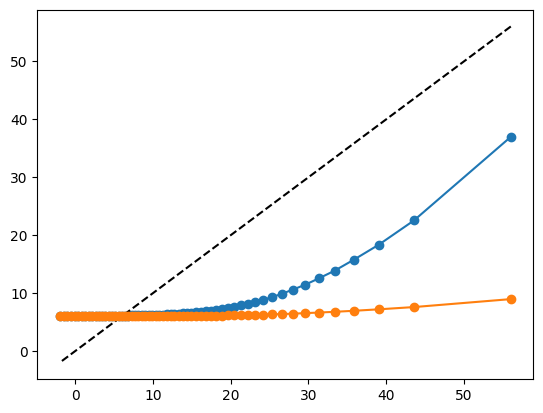

In [34]:
import matplotlib.pyplot as plt
plt.plot(psnr_in_train_array, psnr_out_train_array, marker='o')
plt.plot(psnr_in_train_array, psnr_in_train_array, linestyle='--', c='k')
plt.plot(psnr_in_val_array, psnr_out_val_array, marker='o')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_psnr(psnr_list,psnr_list_test):

    fig , axs = plt.subplots(1,2 , figsize= (12,5), sharey = True)
    axs[0].plot( range(len(psnr_list)), psnr_list, 'orange','-o', label = 'train')
    axs[0].set_ylabel('PSNR')
    #axs[0].set_title('max train psnr ' + str(round(max(psnr_list),3)) + ' from epoch ' + str(psnr_list.index(max(psnr_list))) + '\n final psnr '+str(round(psnr_list[-1],3)))
    axs[0].legend()
    axs[1].plot( range(len(psnr_list_test)), psnr_list_test, 'green','-o', label = 'test')
    #axs[1].set_title('max test psnr ' + str(round(max(psnr_list_test),3)) + ' from epoch ' + str(psnr_list_test.index(max(psnr_list_test))) + '\n final psnr '+str(round(psnr_list_test[-1],3)))
    axs[1].legend()    
    #plt.savefig(file_name)

In [ ]:
psnr_train

In [ ]:
plot_psnr(psnr_train, psnr_val)

## Sample

In [ ]:
from diffusion.sampler import sample
import matplotlib.pyplot as plt

# sample 64 images
samples = sample(ddpm, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_indexes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

fig, axs = plt.subplots(1, 10, figsize=(20, 8))
for i in range(10):
    idx = random_indexes[i]
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f"Image {idx}")
    axs[i].imshow(samples[-1][idx].reshape(image_size, image_size, channels), cmap="gray")
plt.show()

In [ ]:
import matplotlib.animation as animation

random_index = 5

fig = plt.figure()
ims = []
for i in range(timesteps):
    plt.title(f"T = {i}")
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion64x64.gif')
plt.show()